In [1]:
from itertools import product

In [2]:
from cpa_utils import *

# Elisabeth-b4 - Filter block

## Attacking the filter S-boxes

In [3]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"
locations_path = "correlation_locations_b4_two_last_rounds.pic"

In [4]:
seeds, traces, real_keys, correlation_locations = load_data(traces_path, key_path, locations_path)

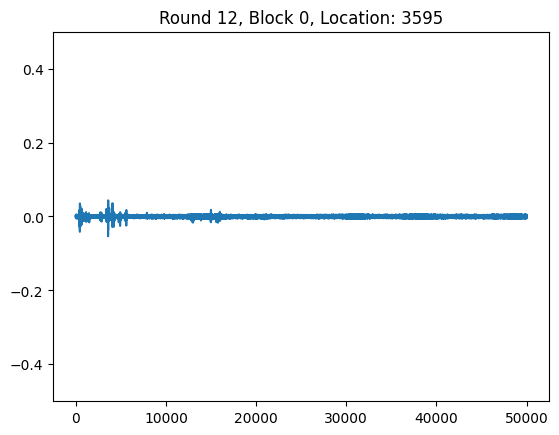

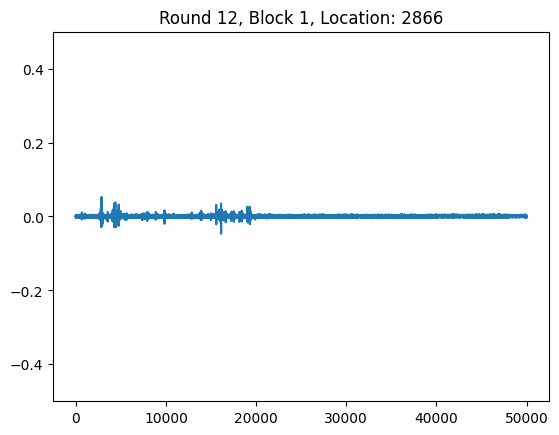

KeyboardInterrupt: 

In [5]:
find_locations_in_time(seeds, traces, real_keys, "correlation_locations_b4_two_last_rounds_hd.pic")

In [7]:
def indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx: int, block_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    if not (0 <= block_target_idx < BLOCK_WIDTH_B4 - 1):
        return None

    key_space = (16,) if block_target_idx % 2 == 0 else (16, 16)
    location_mask_per_trace = np.zeros(total_traces.shape, dtype=bool)
    hypotheses = np.zeros(key_space + total_seeds.shape, dtype=int)

    if block_target_idx % 2 != 0:
        other_key_target_indices = np.zeros_like(total_seeds, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4

            # For now, we only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            # TO REMOVE IF BETTER IDEA IS FOUND
            #if block_idx == BLOCK_WIDTH_B4 - 1 or block_idx % 2 != 0:
            #if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 or block_idx != 4:
            if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != block_target_idx:
                continue
            # TO REMOVE IF BETTER IDEA IS FOUND

            if block_idx != BLOCK_WIDTH_B4 - 1:
                if block_idx % 2 == 0:
                    for k in range(16):
                        block = [0] * BLOCK_WIDTH_B4
                        block[block_idx] = (k + whitening[keyround_target_idx]) % 16

                        sbox_in = block[block_idx]
                        sbox_out = s_boxes_b4[block_idx][sbox_in]

                        hypotheses[k][i] = HD[sbox_in][sbox_out]
                else:
                    for k1, k2 in product(range(16), range(16)):
                        block = [0] * BLOCK_WIDTH_B4
                        block[block_idx] = (k1 + whitening[keyround_target_idx]) % 16
                        block[block_idx - 1] = (k2 + whitening[keyround_target_idx - 1]) % 16

                        sbox_in = (block[block_idx] + block[block_idx - 1]) % 16
                        sbox_out = s_boxes_b4[block_idx][sbox_in]
                        
                        hypotheses[k1][k2][i] = HD[sbox_in][sbox_out]
                    other_key_target_indices[i] = indices[keyround_target_idx - 1]
        
                location_mask_per_trace[i][locations[round_idx][block_idx]] = True
            else:
                raise ValueError("Should not happen")
                for i in range(3):
                    block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
                y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
                z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
                z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
                t_0 = (z[0] + z[1] + z[2]) % 16
                t_0 = (t_0 + block[block_idx - 1]) % 16
                sbox_out = s_boxes_b4[12][t_0]

                hypotheses[i] = HW[(block[block_idx] + sbox_out) % 16]
    
    if block_target_idx % 2 == 0:
        return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)]
    else:
        return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)], other_key_target_indices

In [8]:
def indices_locations_and_hyps_to_use_for_each_key_nibble(key_target_idx: int, block_target_indices: set[int], total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
    if any([not (0 <= b < BLOCK_WIDTH_B4 - 1) for b in block_target_indices]):
        return None

    return [indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx, b, total_seeds, total_traces, locations) for b in block_target_indices]

Key 0: 

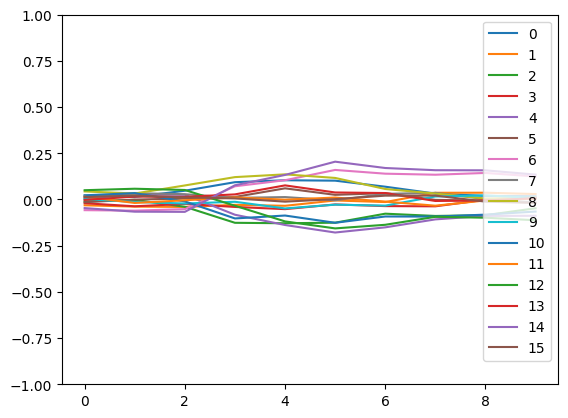

E[ 0.10401912  0.03653996 -0.00224701  0.00612848  0.02720157  0.06029717
  0.15984814  0.03589732  0.13592822  0.02210609  0.03444234  0.01497583
  0.05813042  0.07628001  0.20456738  0.0210167 ]


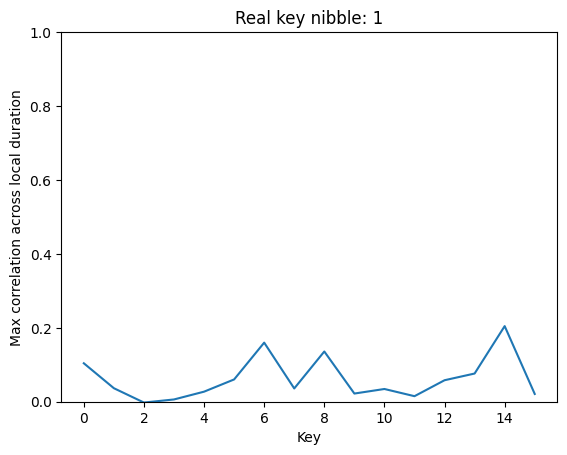

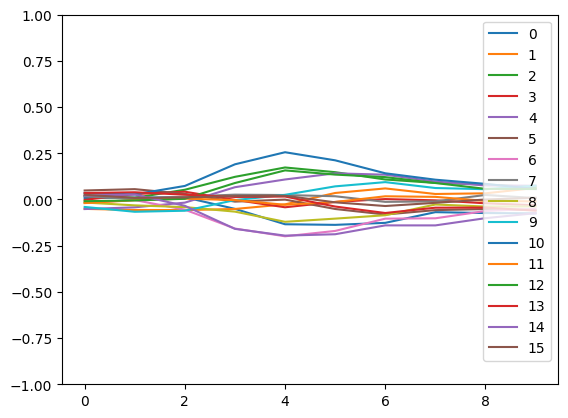

A[ 0.0118237   0.06250414  0.17312781  0.04209487  0.1414594   0.05589392
 -0.00316125  0.02611935 -0.01637349  0.09390285  0.25566213  0.01727115
  0.15739594  0.0389736   0.02655241  0.02551777]


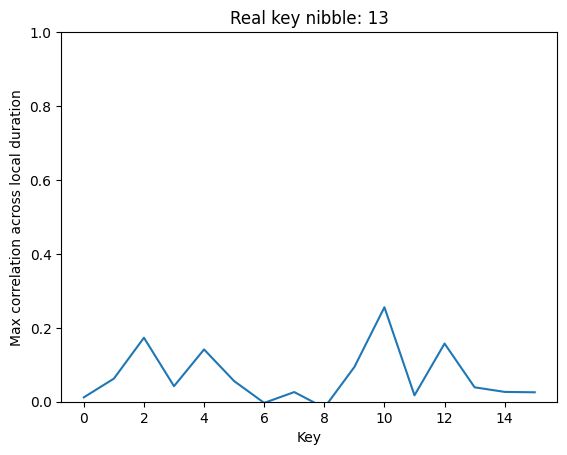

KeyboardInterrupt: 

In [9]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    visited = set()
    for j in range(reconstructed_keys.shape[1]):
        block_targets = [4]
        locs_and_hyps_per_block_target = indices_locations_and_hyps_to_use_for_each_key_nibble(j, block_targets, seeds[i], traces[i], correlation_locations)
        for k, block in enumerate(block_targets):
            if block % 2 == 0:
                selected_traces, hypotheses = locs_and_hyps_per_block_target[k]
                corrs = np.array([corr_coef_vectorized(hypotheses[l], selected_traces) for l in range(hypotheses.shape[0])])
            else:
                selected_traces, hypotheses, other_key_indices = locs_and_hyps_per_block_target[k]
                corrs = np.max([[corr_coef_vectorized(hypotheses[k1][k2], selected_traces) for k2 in range(hypotheses.shape[1])] for k1 in range(hypotheses.shape[0])], axis=1)

            for l in range(len(corrs)):
                plt.plot(corrs[l], label=str(l))

            plt.ylim([-1, 1])
            plt.legend()
            plt.show()
            
            max_corrs = np.max(corrs, axis=1)
            best_k = np.argmax(max_corrs)
            reconstructed_keys[i][j] = best_k

            if block % 2 != 0:
                pass
                #reconstructed_keys[i][other_key_indices[]]

            print(hex(best_k)[2:].upper(), end="")

            print(max_corrs)
            plt.plot(max_corrs)
            plt.xlabel("Key")
            plt.ylabel("Max correlation across local duration")
            plt.title(f"Real key nibble: {real_keys[i][j]}")
            plt.ylim([0, 1])
            plt.show()
    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()